In [2]:
import rasterio as rio
from rasterio.plot import show
import cufflinks as cf
import numpy as np
import xarray as xa
import rioxarray as riox
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from ipywidgets import interact, Button
from plotly.offline import init_notebook_mode, plot, iplot
from sklearn import preprocessing
import scipy as sp
import plotly.express as px
from specutils import Spectrum1D
import astropy.units as u
import numpy as np
import cv2
import os.path
import pysptools.spectro as spectro
from specutils.manipulation import (box_smooth, gaussian_smooth, trapezoid_smooth)
from sympy import *
import MoonIndex.preparation
import MoonIndex.plotting
import MoonIndex.filtration
import MoonIndex.indexes
from sklearn.preprocessing import MinMaxScaler

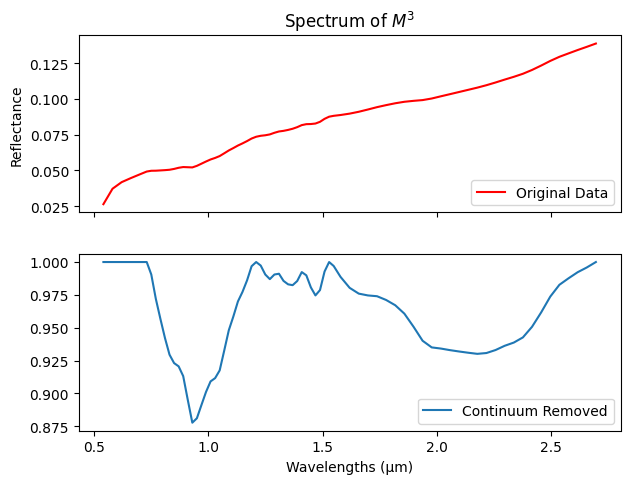

In [80]:
#Figure 2 article
xa,ya=65,65
wavelengths=wavelengths_full[0:76]
average4=M3_gauss.data[0:76,xa,ya]
    
add_point=np.where(wavelengths==M3_midpoint.data[xa,ya])[0]
add_array2=np.vstack((wavelengths[add_point], M3_gauss.data[add_point,xa,ya])).T
    
points = np.c_[wavelengths, average4]
wavelengths, average4 = points.T
augmented = np.concatenate([points, [(wavelengths[0], np.min(average4)-1), (wavelengths[-1], np.min(average4)-1)]], axis=0)
hull = sp.spatial.ConvexHull(augmented)
pre_continuum_points2 = points[np.sort([v for v in hull.vertices if v < len(points)])]
pre_continuum_points22 = np.concatenate((pre_continuum_points2,add_array2), axis=0)
pre_continuum_points22.sort(axis=0)
continuum_points2=np.unique(pre_continuum_points22,axis=0)
continuum_function2 = sp.interpolate.interp1d(*continuum_points2.T)
average4_prime = average4 / continuum_function2(wavelengths)
average4_prime[average4_prime >= 1]= 1
    
fig, axes = plt.subplots(2, 1, sharex=True)
fig.tight_layout(pad=2.0)
axes[0].plot(wavelengths, average4, label='Original Data', color='red')
axes[0].set_title(r'Spectrum of $M^3$')
axes[0].legend(loc=4)
axes[1].plot(wavelengths, average4_prime, label='Continuum Removed')
axes[1].set(xlabel='Wavelengths (μm)')
axes[0].set(ylabel='Reflectance')
axes[1].legend()
fig.savefig(f'{path_results}/{target}Figure2.jpg',dpi=300,bbox_inches='tight')

/tmp/ipykernel_1203345/3055054612.py:19: RuntimeWarning:

divide by zero encountered in log



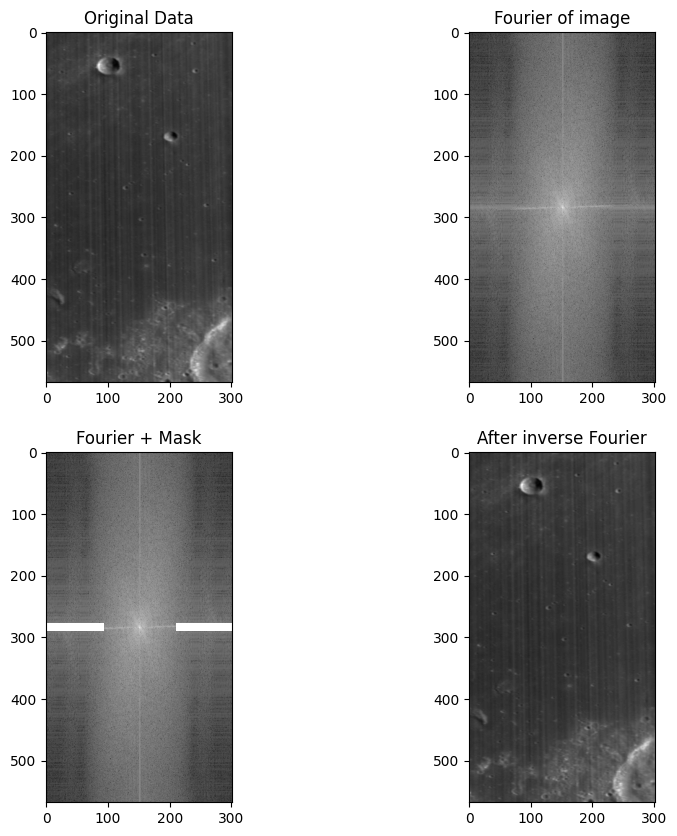

In [42]:
#Figure 6 article
def fourier_plot (gauss_filter2,band,percentage_width, percentage_high):
    fouraster2=cv2.dft(gauss_filter2.data[band,:,:], flags=cv2.DFT_COMPLEX_OUTPUT) 
    fouraster2_shift=np.fft.fftshift(fouraster2)
    magnitude_spectrum = 20 * np.log((cv2.magnitude(fouraster2_shift[:, :, 0], fouraster2_shift[:, :, 1])))  #For plotting
    y3,z3=gauss_filter2.data[band,:,:].shape
    
    rows, cols =gauss_filter2[band,:,:].shape
    mask = np.ones((rows, cols, 2), np.uint8)
    
    filter_width2=int((z3*((100-percentage_width)/100))/2)
    filter_high2=int((y3*(percentage_high/100))/2)

    #Valentine Mask
    cv2.rectangle(mask, (0,((y3//2)-filter_high2)), (((z3//2)-filter_width2),((y3//2)+filter_high2)), 0, -1)
    cv2.rectangle(mask, (((z3//2)+filter_width2),((y3//2)-filter_high2)), (z3,((y3//2)+filter_high2)), 0, -1)

    #Mask applciation and reverse-fourier
    mfouraster2=fouraster2_shift*mask
    mshift_mask_mag = 20 * np.log(cv2.magnitude(mfouraster2[:, :, 0], mfouraster2[:, :, 1]))  #For plotting
    m_ishift2 = np.fft.ifftshift(mfouraster2)


    return_raster2=cv2.idft(m_ishift2)/(y3*z3)
    return_raster2= cv2.magnitude(return_raster2[:, :, 0], return_raster2[:, :, 1])
    
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(gauss_filter2.data[band,:,:], cmap="gray")
    ax1.title.set_text('Original Data')
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(magnitude_spectrum, cmap="gray")
    ax2.title.set_text('Fourier of image')
    ax3 = fig.add_subplot(2,2,3)
    ax3.imshow(mshift_mask_mag, cmap="gray")
    ax3.title.set_text('Fourier + Mask')
    ax4 = fig.add_subplot(2,2,4)
    ax4.imshow(return_raster2.data, cmap="gray")
    ax4.title.set_text('After inverse Fourier')
    return fig
fig=fourier_plot(M3_cube,0,60,2)
fig.savefig(f'{path_results}/{target}Figure6.jpg',dpi=300,bbox_inches='tight')

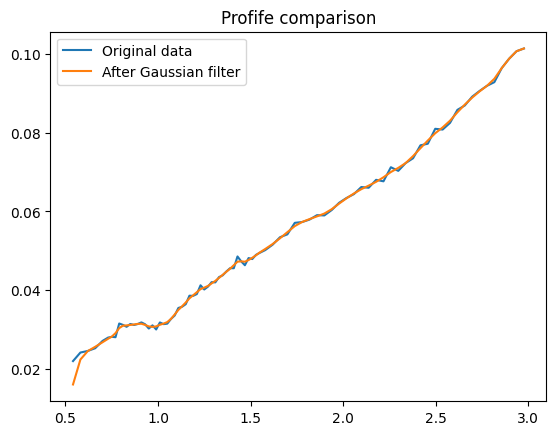

In [53]:
def profiles_comparison(wavelengths,first_cube, second_cube,tittle1,tittle2, in_x, in_y,roi):

    stack_averaw=[]  
    roi_plus=int((roi/2)+0.5)  #Definign the window
    roi_minus=int((roi/2)-0.5)
    for band in range(first_cube.data.shape[0]):
        
        raw_cube2=first_cube[band,:,:]
        neighbourhood = raw_cube2[in_y-roi_minus:in_y+roi_plus, in_x-roi_minus:in_x+roi_plus]  #Slicing the data to the ROI
        average=np.mean(neighbourhood)  #Average of the pixels
        
        stack_averaw.append(average)
    first_average=np.array(stack_averaw)
    
    stack_avegauss=[]
    for band in range(second_cube.data.shape[0]):  #Same for the filtered profile
        
        gauss_cube2=second_cube[band,:,:]  
        neighbourhood2 = gauss_cube2[in_y-roi_minus:in_y+roi_plus, in_x-roi_minus:in_x+roi_plus]
        average2=np.mean(neighbourhood2)
        
        stack_avegauss.append(average2)
    second_average=np.array(stack_avegauss)
    
    plt.plot(wavelengths[0:len(first_average)], first_average, label=tittle1)
    plt.plot(wavelengths[0:len(second_average)],second_average, label=tittle2)
    plt.legend()
    plt.title("Profife comparison")
    return plt
fig3=profiles_comparison(wavelengths_full,M3_fourier.data,M3_gauss.data,"Original data","After Gaussian filter",123, 245,3)  #Inputs are the cubes to compare, wavelengths, their names, pixel x, y, and roi
fig3.savefig(f'{path_results}/{target}Figure7.jpg',dpi=300,bbox_inches='tight')

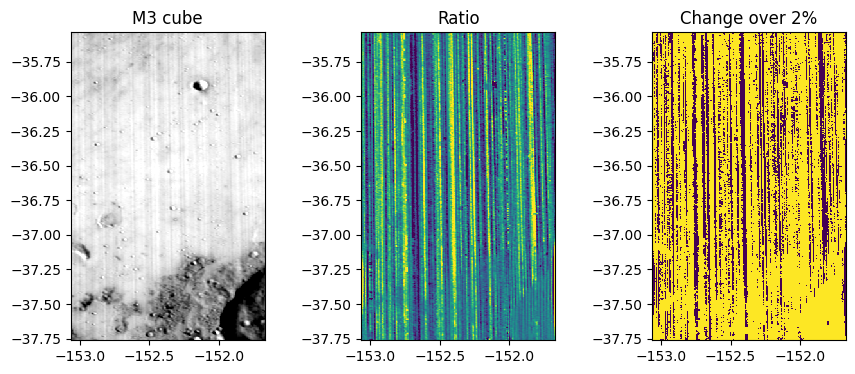

In [110]:
def filter_comaprison (cube_1,cube_2,title1,title2,band):

    ratio_cubes=cube_1/cube_2  #Ratio of the two images

    cube_plus=cube_1+(cube_1*0.02)  #Calculating which pixels changed more than 2%
    cube_minus=cube_1-(cube_1*0.02)
    ratio_plus=cube_plus-cube_2
    ratio_minus=cube_2-cube_minus
    change_ratio=ratio_plus*ratio_minus
    change_ratio.data[change_ratio.data < 0]= 0
    change_ratio.data[change_ratio.data > 0]= 1


    fig4, axs = plt.subplots(ncols=3,nrows=1,figsize=(10,4))  #Plotting
    cube_1[band,:,:].plot.imshow(ax=axs[0],add_colorbar=False,robust=True, add_labels=False, cmap="binary")
    axs[0].title.set_text(title1)
    plt.subplots_adjust(wspace=0.5,hspace=2)
    ratio_cubes[band,:,:].plot.imshow(ax=axs[1],add_colorbar=False,robust=True, add_labels=False)
    axs[1].title.set_text('Ratio')
    change_ratio[band,:,:].plot.imshow(ax=axs[2],add_colorbar=False,robust=True, add_labels=False)
    axs[2].title.set_text('Change over 2%')
    
    return fig4
fig4=filter_comaprison(M3_cube,M3_gauss,"M3 cube", "M3 gauss",40) #Inputs are the cubes to compare, their names, and the band
fig4.savefig(f'{path_results}/{target}Figure7b.jpg',dpi=300,bbox_inches='tight')

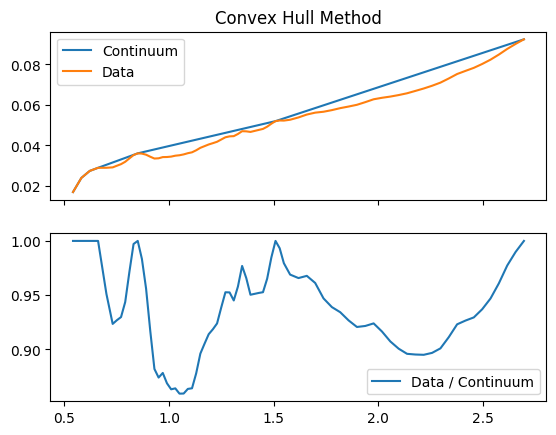

In [183]:
#Figure 8
def convexhull_plot(fourier_cube, wavelengths_full,mid_point,y_hull,x_hull):

    wavelengths=wavelengths_full[0:76]
    average4=fourier_cube[0:76,x_hull,y_hull]
    
    add_point=np.where(wavelengths==mid_point[x_hull,y_hull])[0]
    add_array2=np.vstack((wavelengths[add_point], fourier_cube[add_point,x_hull,y_hull])).T
    
    points = np.c_[wavelengths, average4]
    wavelengths, average4 = points.T
    augmented = np.concatenate([points, [(wavelengths[0], np.min(average4)-1), (wavelengths[-1], np.min(average4)-1)]], axis=0)
    hull = sp.spatial.ConvexHull(augmented)
    pre_continuum_points2 = points[np.sort([v for v in hull.vertices if v < len(points)])]
    pre_continuum_points22 = np.concatenate((pre_continuum_points2,add_array2), axis=0)
    pre_continuum_points22.sort(axis=0)
    continuum_points2=np.unique(pre_continuum_points22,axis=0)
    continuum_function2 = sp.interpolate.interp1d(*continuum_points2.T)
    average4_prime = average4 / continuum_function2(wavelengths)
    average4_prime[average4_prime >= 1]= 1
    
    fig, axes = plt.subplots(2, 1, sharex=True)
    axes[0].set_title("Convex Hull Method")
        axes[0].plot(*continuum_points2.T, label='Continuum')
    axes[0].plot(wavelengths, average4, label='Data')
    axes[0].legend()
    axes[1].plot(wavelengths, average4_prime, label='Data / Continuum')
    axes[1].legend()

    return fig
fig7=convexhull_plot(M3_gauss.data,wavelengths_full, M3_midpoint.data,32,40) #Inputs are filtered cube, wavelengths, midpoint,x, y and ROI
fig7.savefig(f'{path_results}/{target}Figure8a.jpg',dpi=300,bbox_inches='tight')

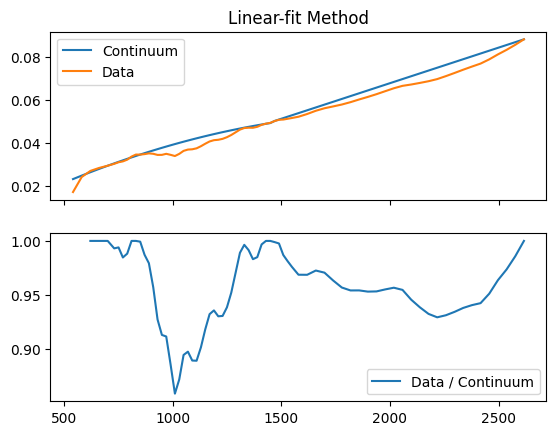

In [190]:
lf_cube=M3_gauss.data[0:74,32,40]  #Second order fit for 1000 nm, it used a range for the two shoudlers around the 1000 nm absorption
fitx10001=wavelengths[1:7]
fitx10002=wavelengths[39:42]
fitx1000=np.hstack((fitx10001,fitx10002))
fity10001=lf_cube[1:7]
fity10002=lf_cube[39:42]
fity1000=np.hstack((fity10001,fity10002))
fit1000=np.polyfit(fitx1000,fity1000,2)
polival1000=np.polyval(fit1000,wavelengths[0:42])

fitx2000=np.hstack((fitx10002,wavelengths[73])) #Fit for 2000 nm, linear
fity2000=np.hstack((fity10002,lf_cube[73]))
fit2000=np.polyfit(fitx2000,fity2000,1)
polival2000=np.polyval(fit2000,wavelengths[42:74])

continuum=np.hstack((polival1000,polival2000))  #Continuum removal by dividing
continum_removed=M3_lf[:,32,40]

fig6, axes = plt.subplots(2, 1, sharex=True)
axes[0].set_title("Linear-fit Method")
axes[0].plot(wavelengths[0:74],continuum,label='Continuum')
axes[0].plot(wavelengths[0:74],M3_gauss.data[0:74,32,40],label='Data')
axes[0].legend()
axes[1].plot(wavelengths[2:74], continum_removed[2:74], label='Data / Continuum')
axes[1].legend()
fig6.savefig(f'{path_results}/{target}Figure8b.jpg',dpi=300,bbox_inches='tight')

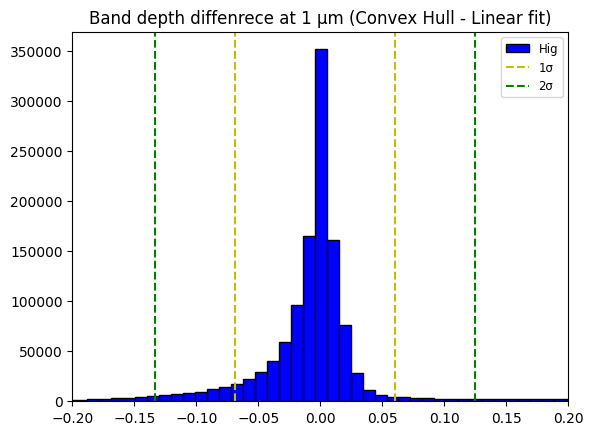

In [24]:
path_data='/home/jovyan/work/Index/scripts' #Path to the data
target="resta"
input_cube=riox.open_rasterio(f'{path_data}/{target}.tif')

BDI_diff=input_cube 
BDI_diff=np.nan_to_num(BDI_diff,nan=0)
BDI_diff=BDI_diff.ravel()
BDI_diff=[x for x in BDI_diff if x <= 1]
BDI_diff=[x for x in BDI_diff if x >= -1]
#BDI_diff[BDI_diff > 1] = 0
#BDI_diff[BDI_diff < -1] = 0
BDI_mean=np.mean(BDI_diff)
BDI_std=np.std(BDI_diff)

fig2=plt.figure()
plt.hist(BDI_diff,bins=200,color=["b"],edgecolor = "Black",histtype="barstacked",label=["Hig"] )

plt.axvline(BDI_mean+BDI_std, color="y", linestyle="dashed", label="1σ")
plt.axvline(BDI_mean-BDI_std, color="y", linestyle="dashed")

plt.axvline(BDI_mean+2*BDI_std, color="g", linestyle="dashed",label="2σ")
plt.axvline(BDI_mean-2*BDI_std, color="g", linestyle="dashed")

plt.xlim([-0.2,0.2])
plt.title("Band depth diffenrece at 1 μm (Convex Hull - Linear fit)")
plt.legend(fontsize="small")
plt.show()
#fig2.savefig(f'{path_results}/{target}Figure14b.jpg',dpi=300,bbox_inches='tight')

In [35]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt

dist=sps.norm(loc=BDI_mean,scale=BDI_std)
# Probability Density Function
pdf = dist.pdf(BDI_diff)
# Cumulative Density Function
cdf = dist.cdf(BDI_diff)

BDIF=np.array(BDI_diff)

cdf_at_8 = BDIF.cdf(BDI_mean-BDI_std)

cdf_at_17 = BDIF.cdf(BDI_mean+BDI_std)

cdf_between_8_17 = cdf_at_17 - cdf_at_8

print(f"{cdf_between_8_17:.1%}")

AttributeError: 'numpy.ndarray' object has no attribute 'cdf'

In [33]:
BDI_diff2=[x for x in BDI_diff if x <= BDI_mean+BDI_std]
BDI_diff2=[x for x in BDI_diff if x >= BDI_mean-BDI_std]
len(BDI_diff2)

1119470

In [32]:
92.3
len(BDI_diff)

1212416

In [3]:
BDI_diff=M3_BDI_LF.data - M3_BDI_CH.data 
BDI_diff=np.nan_to_num(BDI_diff,nan=0)
BDI_diff=BDI_diff.ravel()
BDI_mean=np.mean(BDI_diff)
BDI_std=np.std(BDI_diff)
BDI_t=BDI_diff<-0.00115

fig2=plt.figure()
plt.hist([BDI_diff[BDI_t],BDI_diff[~BDI_t]],bins=200,color=["b","r"],edgecolor = "Black",histtype="barstacked",label=["Higher Convex Hull(24.52%)","Higher Linear fit (75.48%)"] )

plt.axvline(BDI_mean+BDI_std, color="y", linestyle="dashed", label="1σ")
plt.axvline(BDI_mean-BDI_std, color="y", linestyle="dashed")

plt.axvline(BDI_mean+2*BDI_std, color="g", linestyle="dashed",label="2σ")
plt.axvline(BDI_mean-2*BDI_std, color="g", linestyle="dashed")

plt.xlim([-0.1,0.1])
plt.title("Band depth diffenrece at 1 μm (Convex Hull - Linear fit)")
plt.legend(fontsize="small")
plt.show()
fig2.savefig(f'{path_results}/{target}Figure14b.jpg',dpi=300,bbox_inches='tight')

NameError: name 'M3_BDI_LF' is not defined

In [ ]:
BDII_diff=M3_BDII_LF.data - M3_BDII_CH.data 
BDII_diff=np.nan_to_num(BDII_diff,nan=0)
BDII_diff=BDII_diff.ravel()
BDII_mean=np.mean(BDII_diff)
BDII_std=np.std(BDII_diff)
BDII_t=BDII_diff<0.0001

fig3=plt.figure()
plt.hist([BDII_diff[BDII_t],BDII_diff[~BDII_t]],bins=500,color=["b","r"],edgecolor = "Black",histtype="barstacked",label=["Higher Convex Hull(93.86%)","Higher Linear fit (6.24%)"])

plt.axvline(BDII_mean+BDII_std, color="y", linestyle="dashed", label="1σ")
plt.axvline(BDII_mean-BDII_std, color="y", linestyle="dashed")

plt.axvline(BDII_mean+2*BDII_std, color="g", linestyle="dashed",label="2σ")
plt.axvline(BDII_mean-2*BDII_std, color="g", linestyle="dashed")

plt.xlim([-0.05,0.05])
plt.title("Band depth diffenrece at 2 μm (Convex Hull - Linear fit)")
plt.legend(loc=1,fontsize="small")
plt.show()
fig3.savefig(f'{path_results}/{target}Figure14c.jpg',dpi=300,bbox_inches='tight')

In [ ]:
def profiles_comparison(wavelengths,first_cube, second_cube,tittle1,tittle2, in_x, in_y,roi):

    stack_averaw=[]  
    roi_plus=int((roi/2)+0.5)  #Definign the window
    roi_minus=int((roi/2)-0.5)
    for band in range(first_cube.data.shape[0]):
        
        raw_cube2=first_cube[band,:,:]
        neighbourhood = raw_cube2[in_y-roi_minus:in_y+roi_plus, in_x-roi_minus:in_x+roi_plus]  #Slicing the data to the ROI
        average=np.mean(neighbourhood)  #Average of the pixels
        
        stack_averaw.append(average)
    first_average=np.array(stack_averaw)
    
    stack_avegauss=[]
    for band in range(second_cube.data.shape[0]):  #Same for the filtered profile
        
        gauss_cube2=second_cube[band,:,:]  
        neighbourhood2 = gauss_cube2[in_y-roi_minus:in_y+roi_plus, in_x-roi_minus:in_x+roi_plus]
        average2=np.mean(neighbourhood2)
        
        stack_avegauss.append(average2)
    second_average=np.array(stack_avegauss)
    
    plt.plot(wavelengths[1:len(first_average)], first_average[1:83], label=tittle1)
    plt.plot(wavelengths[1:len(second_average)],second_average[1:83], label=tittle2)
    plt.legend()
    plt.title("Profile comparison on the highlands")
    return plt

fig5=profiles_comparison(wavelengths_full,M3_hull,M3_lf, "Convex hull", "Linear fit",80,120,3)
fig5.savefig(f'{path_results}/{target}Figure14a.jpg',dpi=300,bbox_inches='tight')